In [12]:
import geopandas as gpd

data = gpd.read_file("../Data/gjson/adm_3.geojson").sort_values('area', ascending = False)


In [13]:
data.head()

,id,fnid,name,unit_type_code,parent_id,start_date,end_date,country_code,fewsnet_region,geographic_group,...,layer_id,layer_name,geographicunitsetversion_name,zone_type,urban_rural,start_month,area,attributes,fid,geometry
112,222908,ET2023A3020207,Afdera,admin3,222703,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,12805.0,"{'FNID': 'ET2023A3020207', 'ADMIN0': 'Ethiopia...",112,"MULTIPOLYGON (((41.46327 13.50482, 41.45752 13..."
761,223557,ET2023A3050503,Shilabo,admin3,222748,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,12163.0,"{'FNID': 'ET2023A3050503', 'ADMIN0': 'Ethiopia...",761,"POLYGON ((45.25200 6.39700, 45.25369 6.39416, ..."
797,223593,ET2023A3050901,Filtu,admin3,222752,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,11947.0,"{'FNID': 'ET2023A3050901', 'ADMIN0': 'Ethiopia...",797,"POLYGON ((41.15300 5.62500, 41.15200 5.62500, ..."
94,222890,ET2023A3020102,Elidar,admin3,222702,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,11779.0,"{'FNID': 'ET2023A3020102', 'ADMIN0': 'Ethiopia...",94,"POLYGON ((42.13656 12.77686, 42.19289 12.76911..."
742,223538,ET2023A3050304,Gashamo,admin3,222746,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,11398.0,"{'FNID': 'ET2023A3050304', 'ADMIN0': 'Ethiopia...",742,"POLYGON ((46.08956 8.30799, 46.08945 8.30671, ..."


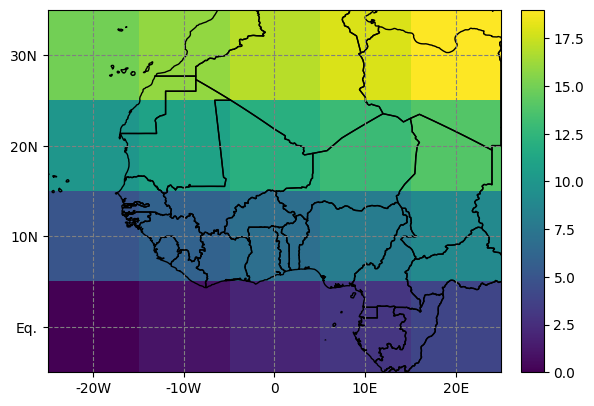

In [14]:
import numpy as np

import xarray as xr

import salem

da = xr.DataArray(np.arange(20).reshape(4, 5), dims=['lat', 'lon'],
                  coords={'lat':np.linspace(0, 30, 4),
                          'lon':np.linspace(-20, 20, 5)})


da.salem
da.salem.quick_map();

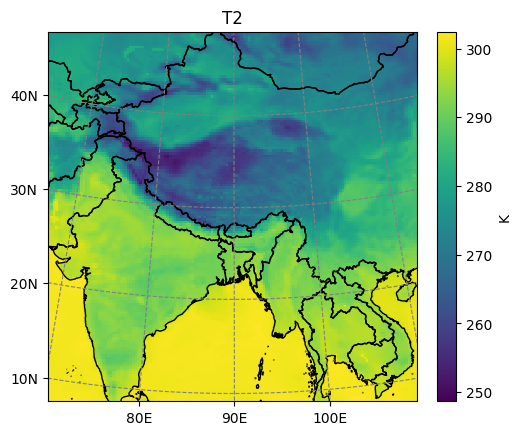

In [15]:
import salem

from salem.utils import get_demo_file

ds = salem.open_xr_dataset(get_demo_file('wrfout_d01.nc'))

t2 = ds.T2.isel(Time=2)

t2.salem.quick_map();

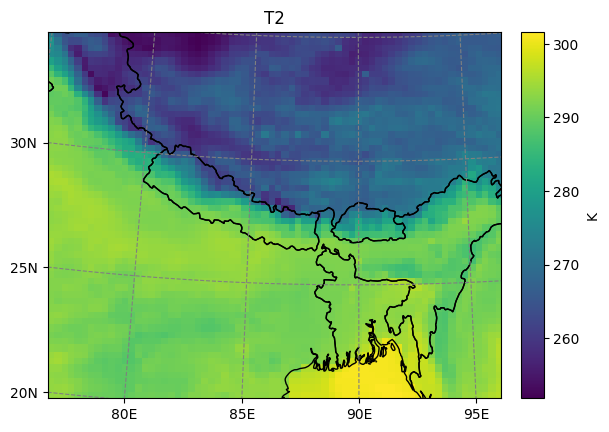

In [16]:
t2_sub = t2.salem.subset(corners=((77., 20.), (97., 35.)), crs=salem.wgs84)

t2_sub.salem.quick_map();

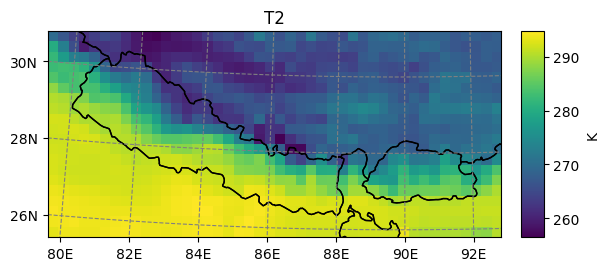

In [17]:
shdf = salem.read_shapefile(get_demo_file('world_borders.shp'))

shdf = shdf.loc[shdf['CNTRY_NAME'].isin(['Nepal', 'Bhutan'])]  # GeoPandas' GeoDataFrame

t2_sub = t2_sub.salem.subset(shape=shdf, margin=2)  # add 2 grid points

t2_sub.salem.quick_map();

In [18]:
type(shdf)

geopandas.geodataframe.GeoDataFrame

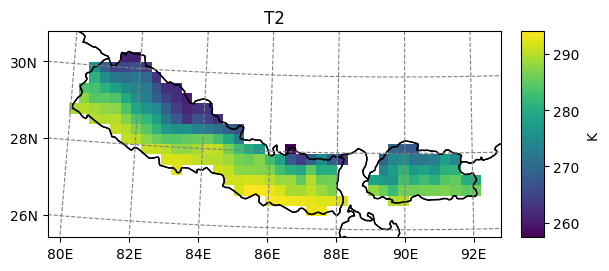

In [19]:
t2_roi = t2_sub.salem.roi(shape=shdf)

t2_roi.salem.quick_map();

In [20]:
fpath = salem.get_demo_file('himalaya.tif')
ds = salem.open_xr_dataset(fpath)
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (x: 1875, y: 877)
Coordinates:
  * x        (x) float64 15kB 78.32 78.33 78.34 78.35 ... 93.92 93.93 93.94
  * y        (y) float64 7kB 31.54 31.53 31.52 31.51 ... 24.26 24.25 24.25 24.24
Data variables:
    data     (y, x) int16 3MB 3600 3853 4269 4599 4622 ... 814 921 977 892 1029
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [21]:
data.head(1).to_file("../output/trash/test.shp")

C:\Users\Jhon\AppData\Local\Temp\ipykernel_12736\1766356876.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data.head(1).to_file("../output/trash/test.shp")


In [22]:
# %%timeit
# dsr = salem.open_xr_dataset('../Data/Raster/settlement/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif')
ds = salem.open_xr_dataset('../Data/Raster/settlement/ethiopia_ghs_masked.tif')
shdf = salem.read_shapefile('../output/trash/test.shp')
# # hmap = dsr.salem.get_map(cmap = 'topo')
# # dsr['data']
# crs = dsr.attrs['pyproj_srs']
# new_shp = shdf.to_crs(crs)
# # hmap.set_data[dsr['data']]
# # hmap.visualize()
# dsr_1 = dsr.salem.subset(shape = new_shp, margin = 10)
ds1 = ds.salem.subset(shape = shdf, margin = 10)
df = ds1['data'].to_pandas().reset_index()

df.melt(id_vars = ['y'],)

MemoryError: Unable to allocate 79.1 GiB for an array with shape (1, 142174, 149261) and data type float32

In [87]:
%%time
import rasterio as rio, pandas as pd
from rasterio.mask import mask
def get_data_raster_shapefile(
    shp_gdf: gpd.GeoDataFrame ,
    path_tiff: str = '../Data/Raster/Population/eth_ppp_2020_constrained.tif',
    cols_dataref=["admin_0", "admin_1", "admin_2", "admin_3"],
    metrics=[np.mean, np.std, np.sum],
    metric_value="population",
):

    with rio.open(path_tiff) as src:
        out_image, out_transform = mask(src, shp_gdf.geometry, crop=True)
    temp_gdf = shp_gdf.copy()
    shp_gdf = shp_gdf[cols_dataref]
    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())
    data = {"x": x, "y": y, "z": values}
    data = pd.DataFrame(data)
    return data


get_data_raster_shapefile(shp_gdf=shdf)

15.3 s ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# append raster
import rasterio
from rasterio.merge import merge
from rasterio import Affine as affine
import glob, os

In [8]:
files = glob.glob("../Data/Raster/settlement/Each/" + "*.tif")
rasters = []
for file in files[:2]:
    raster = rasterio.open(file)
    rasters.append(raster)
print("merge")
mosaico, transform = merge(rasters)

perfil = rasters[0].profile
perfil.update(
    {"height": mosaico.shape[1], "width": mosaico.shape[2], "transform": transform}
)
with rasterio.open('../output/trash/test_union.tif', 'w', **perfil) as dst:
    dst.write(mosaico)

for raster in rasters:
    raster.close()

In [2]:
r_tiff = '../Data/Raster/settlement/ethiopia_ghs.tif'
from rasterio.plot import show
import rasterio

# Ruta al archivo raster

# Abrir el raster con rasterio
with rasterio.open(r_tiff) as src:
    # Visualizar el raster
    show(src)